In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
import random

# import for sub-routine !!
from typing import Iterable, Optional, Dict, Any, Tuple
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

# import dataset and do data preparation 
adult_tmp = pd.read_csv("C:\\Users\\pixal\\Desktop\\WPy64-312101\\notebooks\\adult\\adult_with_heading.csv")
adult_tmp['cap-gain-loss'] = adult_tmp['capital-gain'] + adult_tmp ['capital-loss']

# column has prefix space. Finally space removed by hand as programming is troublesome!
# adult_tmp.loc[:,'marital-status'] = adult_tmp['marital-status'].str.lstrip()  

mar_cat = adult_tmp[['marital-status']]
mar_cat = mar_cat.replace({'Married-AF-spouse':'Married', 'Married-civ-spouse':'Married', 'Married-spouse-absent':'Married'})
dummies = pd.get_dummies(mar_cat['marital-status'], dtype='uint8')
adult_tmp = pd.concat((adult_tmp, dummies), axis=1)

In [2]:
#
# sub-routine
#
def sweep_max_leaf_nodes(
    X,
    y,
    max_leaf_nodes_range: Iterable[int],
    *,
    clf_params: Optional[Dict[str, Any]] = None,
    cv: int = 5,
    scoring: Optional[str] = None,
    verbose: bool = False
) -> Tuple[pd.DataFrame, DecisionTreeClassifier]:
    """
    Evaluate DecisionTreeClassifier over a range of max_leaf_nodes.

    Parameters
    - X, y: training data (array-like / DataFrame / Series).
    - max_leaf_nodes_range: iterable of positive integers to test.
    - clf_params: optional dict of extra DecisionTreeClassifier parameters.
    - cv: cross-validation folds (default 5).
    - scoring: scoring string passed to cross_val_score (default None -> estimator.score).
    - verbose: if True prints progress.

    Returns
    - results_df: pandas DataFrame with columns ['max_leaf_nodes', 'mean_score', 'std_score'] sorted by max_leaf_nodes.
    - best_model: DecisionTreeClassifier fitted on the full X,y with the best max_leaf_nodes (highest mean_score).
    """
    if clf_params is None:
        clf_params = {}

    rows = []
    for m in sorted(set(int(v) for v in max_leaf_nodes_range if int(v) > 0)):
        clf = DecisionTreeClassifier(max_leaf_nodes=m, **clf_params)
        scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
        mean, std = float(np.mean(scores)), float(np.std(scores))
        rows.append({"max_leaf_nodes": m, "mean_score": mean, "std_score": std})
        if verbose:
            print(f"max_leaf_nodes={m}  mean_score={mean:.4f}  std={std:.4f}")

    results_df = pd.DataFrame(rows).sort_values("max_leaf_nodes").reset_index(drop=True)

    best_row = results_df.loc[results_df["mean_score"].idxmax()]
    best_m = int(best_row["max_leaf_nodes"])
    best_model = DecisionTreeClassifier(max_leaf_nodes=best_m, **clf_params)
    best_model.fit(X, y)

    return results_df, best_model

In [3]:
adult_tmp

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,capital-loss,hours-per-week,native-country,class,cap-gain-loss,Divorced,Married,Never-married,Separated,Widowed
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,0,40,United-States,<=50K,2174,0,0,1,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,0,13,United-States,<=50K,0,0,1,0,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,0,40,United-States,<=50K,0,1,0,0,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,...,0,40,United-States,<=50K,0,0,1,0,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,...,0,40,Cuba,<=50K,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,...,0,38,United-States,<=50K,0,0,1,0,0,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,...,0,40,United-States,>50K,0,0,1,0,0,0
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,...,0,40,United-States,<=50K,0,0,0,0,0,1
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,...,0,20,United-States,<=50K,0,0,0,1,0,0


In [4]:
# partition dataset
adult_train, adult_test = train_test_split(adult_tmp, test_size= 0.25, random_state = 7)

In [5]:
# extract data set for training
y = adult_train[['class']]
x = adult_train[['cap-gain-loss', 'Divorced', 'Married', 'Never-married',
       'Separated', 'Widowed']]

In [6]:
x

,cap-gain-loss,Divorced,Married,Never-married,Separated,Widowed
22659,0,0,0,1,0,0
25090,0,0,0,1,0,0
18617,0,0,0,1,0,0
8482,0,0,0,1,0,0
1544,0,1,0,0,0,0
...,...,...,...,...,...,...
5699,0,0,0,1,0,0
10742,0,0,1,0,0,0
16921,0,0,1,0,0,0
25796,2415,0,1,0,0,0


In [7]:
y

,class
22659,<=50K
25090,<=50K
18617,<=50K
8482,<=50K
1544,<=50K
...,...
5699,<=50K
10742,<=50K
16921,<=50K
25796,>50K


In [8]:
# the index is in randomly sequence so we need to reset it !! (you can notice from above x,y values !!
adult_train = adult_train.reset_index()
adult_test = adult_test.reset_index()

In [9]:
# notice the index sequence below after index were reseted !!
adult_train

,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,...,capital-loss,hours-per-week,native-country,class,cap-gain-loss,Divorced,Married,Never-married,Separated,Widowed
0,22659,22,Private,34616,Some-college,10,Never-married,Sales,Not-in-family,White,...,0,30,United-States,<=50K,0,0,0,1,0,0
1,25090,31,Private,91666,HS-grad,9,Never-married,Exec-managerial,Own-child,White,...,0,60,United-States,<=50K,0,0,0,1,0,0
2,18617,25,Private,193773,HS-grad,9,Never-married,Other-service,Not-in-family,Black,...,0,35,United-States,<=50K,0,0,0,1,0,0
3,8482,26,Private,247025,HS-grad,9,Never-married,Protective-serv,Unmarried,White,...,0,44,United-States,<=50K,0,0,0,1,0,0
4,1544,69,?,473040,5th-6th,3,Divorced,?,Not-in-family,White,...,0,40,United-States,<=50K,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24415,5699,23,Private,149224,HS-grad,9,Never-married,Sales,Not-in-family,White,...,0,40,United-States,<=50K,0,0,0,1,0,0
24416,10742,37,Private,231180,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,...,0,40,United-States,<=50K,0,0,1,0,0,0
24417,16921,27,Self-emp-not-inc,140863,9th,5,Married-civ-spouse,Craft-repair,Husband,White,...,0,40,United-States,<=50K,0,0,1,0,0,0
24418,25796,46,Private,456062,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,...,2415,55,United-States,>50K,2415,0,1,0,0,0


In [10]:
# extract data set for training
y = adult_train[['class']]
x = adult_train[['cap-gain-loss', 'Divorced', 'Married', 'Never-married',
       'Separated', 'Widowed']]

In [11]:
y1 = adult_train['class']  # data type of y1 is series of pandas where y is dataFrame !!
type(y1)                   # change data type to series for Naive Bayes Classification !!

pandas.core.series.Series

In [12]:
type(y)

pandas.core.frame.DataFrame

### Build Model

In [13]:
# build Decision Tree

dtc5_model = DecisionTreeClassifier(criterion = "gini", max_leaf_nodes=29)
evaluate_model(dtc5_model, "Decision Tree - gini")

# build Decision Tree with entropy
dt_model = DecisionTreeClassifier(criterion = "entropy", max_leaf_nodes=72).fit(x,y)
evaluate_model(dt_model, "Decision Tree - entropy")

# use Navie Bayes classification
nb_model = GaussianNB().fit(x,y1) # not use "MultinomialNB"
evaluate_model(nb_model, "Naive Bayes")

# XGBoot
xgb_model = xgb.XGBClassifier(
    # use_label_encoder=False,  # Avoids warnings in newer versions
    eval_metric='mlogloss'  # Multiclass log loss for evaluation
)

### Make Decison Tree Graph

In [14]:
# Make Decison Tree Graph
# make columns heading for Decision Tree graph
y_names=["<=50K", ">50K"]
x_names=["cap-gain-loss", "Divorced", "Married", "Never-married", "Separated",	"Widowed"]

# export Decision Tree Graph
export_graphviz(cart01, out_file="D:\\wb\\python\\ML\\adult\\cart01.dot", 
feature_names=x_names, class_names=y_names)

export_graphviz(cart02, out_file="D:\\wb\\python\\ML\\adult\\cart02.dot", 
feature_names=x_names, class_names=y_names)

### Test model

In [15]:
# test model with test dataset !
x_test = adult_test[['cap-gain-loss', 'Divorced', 'Married', 'Never-married',
       'Separated', 'Widowed']]

predClassCART = cart01.predict(x_test)

# test another decision tree (entropy)
predClassCART_C5 = cart02.predict(x_test)

predClass_NB = nb_01.predict(x_test)

predClass_xgb = xgb_model.predict(x_test)


In [16]:
type(predClassCART)

numpy.ndarray

In [17]:
type(predClass_NB)

numpy.ndarray

In [18]:
predClass_NB

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '<=50K'],
      shape=(8141,), dtype='<U5')

In [19]:
# crosstab accept dataFrame only !! and the predict result is arry, so it need be converted
predClassCART = pd.Series(predClassCART, name='predict') # convert array to Series for the result from CART

predClassCART_C5 = pd.Series(predClassCART_C5, name='predict_c5') # convert array to Series for the result from C5 (entropy)

predClass_NB = pd.Series(predClass_NB, name='predict_NB') # convert array to Series for the result from Navie Bayes

adult_predict = pd.concat((adult_test, predClassCART, predClassCART_C5, predClass_NB), axis=1) 


In [20]:
type(predClassCART)

pandas.core.series.Series

In [21]:
adult_predict

,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,...,class,cap-gain-loss,Divorced,Married,Never-married,Separated,Widowed,predict,predict_c5,predict_NB
0,18329,39,Private,81487,Some-college,10,Divorced,Exec-managerial,Unmarried,White,...,<=50K,625,1,0,0,0,0,<=50K,<=50K,<=50K
1,997,48,Federal-gov,33109,Bachelors,13,Divorced,Exec-managerial,Unmarried,White,...,>50K,0,1,0,0,0,0,<=50K,<=50K,<=50K
2,13225,22,Private,60331,Some-college,10,Married-civ-spouse,Other-service,Husband,White,...,<=50K,0,0,1,0,0,0,<=50K,<=50K,<=50K
3,6837,23,State-gov,186634,12th,8,Never-married,Exec-managerial,Not-in-family,White,...,<=50K,0,0,0,1,0,0,<=50K,<=50K,<=50K
4,29132,50,Self-emp-not-inc,334273,Bachelors,13,Married-civ-spouse,Sales,Husband,White,...,<=50K,0,0,1,0,0,0,<=50K,<=50K,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,5363,28,Self-emp-not-inc,160786,HS-grad,9,Never-married,Craft-repair,Own-child,White,...,<=50K,0,0,0,1,0,0,<=50K,<=50K,<=50K
8137,26239,27,Local-gov,332785,HS-grad,9,Never-married,Protective-serv,Own-child,White,...,<=50K,0,0,0,1,0,0,<=50K,<=50K,<=50K
8138,30359,24,Private,220993,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,...,<=50K,0,0,0,1,0,0,<=50K,<=50K,<=50K
8139,30489,36,Private,185325,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,...,<=50K,0,0,0,1,0,0,<=50K,<=50K,<=50K


In [22]:
ct=pd.crosstab(adult_predict['class'], adult_predict['predict']) # continguancy table for CART

ct_c5=pd.crosstab(adult_predict['class'], adult_predict['predict_c5']) # continguancy table for C5 (entropy)

ct_NB=pd.crosstab(adult_predict['class'], adult_predict['predict_NB']) 

In [23]:
ct_NB

predict_NB,<=50K,>50K
class,,
<=50K,5971,203
>50K,1392,575


In [24]:
ct_c5

predict_c5,<=50K,>50K
class,,
<=50K,6147,27
>50K,1366,601


### Below code is to test calcution

In [25]:
#ct_NB.loc['total']= ct_NB.sum()   # sum vertical
#ct_NB['total']= ct_NB.sum(axis=1) # sum horizon
#ct_NB
ct_NB_tmp = ct_NB.copy()
ct_NB_tmp['total']= ct_NB_tmp.sum(axis=1)
ct_NB_tmp.loc['total']=ct_NB_tmp.sum()
ct_NB_tmp

predict_NB,<=50K,>50K,total
class,,,
<=50K,5971,203,6174
>50K,1392,575,1967
total,7363,778,8141


In [26]:
ct_NB_tmp.iloc[1,0]

np.int64(1392)

In [27]:
TN=ct_NB_tmp.iloc[0,0]
FP=ct_NB_tmp.iloc[0,1]
FN=ct_NB_tmp.iloc[1,0]
TP=ct_NB_tmp.iloc[1,1]
TAN=TN + FP
TAP=FN + TP
TPN=TN + FN
TPP=FP + TP
GT=TAN + TAP

In [28]:
GT


np.int64(8141)

In [29]:
round_digit=2
precision=round((TP / TPP), round_digit)
recall=specificity=round((TN / TAN), round_digit)
sensitivity=round((TP / TAP), round_digit)
accuracy=round(((TN + TP)/GT), round_digit)
error_rate=round((1 - accuracy), round_digit)
print(precision, recall, sensitivity, accuracy, error_rate)

0.74 0.97 0.29 0.8 0.2


In [30]:
def eval_measure(ct,round_digit=2):
    """
    input: contingency table and optional rounding digit 
    return: tuple
    function: calculate precision, recall, sensitivity, accuracy, error_rate
    """
    TN=ct.iloc[0,0]
    FP=ct.iloc[0,1]
    FN=ct.iloc[1,0]
    TP=ct.iloc[1,1]
    TAN=TN + FP
    TAP=FN + TP
    TPN=TN + FN
    TPP=FP + TP
    GT=TAN + TAP
    round_digit=2
    precision=round((TP / TPP), round_digit)
    recall=specificity=round((TN / TAN), round_digit)
    sensitivity=round((TP / TAP), round_digit)
    accuracy=round(((TN + TP)/GT), round_digit)
    error_rate=round((1 - accuracy), round_digit)
    return (precision, recall, sensitivity, accuracy, error_rate)

In [31]:
t1=eval_measure(ct_NB)

In [32]:
type(t1)

tuple

### Main loop for testing model with different parameter ! (leaf_node)

In [57]:
#print("node, precision, recall, sensitivity, accuracy, error_rate")  
eval_report = pd.DataFrame(columns=['leaf_count', 'precision', 'recall', 'sensitivity', 'accuracy', 'error_rate'])
for max_nodes in range(3, 12):
    cart02 = DecisionTreeClassifier(criterion = "entropy", max_leaf_nodes=max_nodes).fit(x,y)
    predClassCART_C5 = cart02.predict(x_test)
    predClassCART_C5 = pd.Series(predClassCART_C5, name='predict_c5') # convert array to Series for the result from C5 (entropy)
    ct_c5=pd.crosstab(adult_predict['class'], predClassCART_C5)       # continguancy table for C5 (entropy)
    eval_result=(precision, recall, sensitivity, accuracy, error_rate)=eval_measure(ct_c5)
    eval_result=tuple((max_nodes,)) + eval_result                     # create tuple with single value need this => (value, ) !!!
    eval_report.loc[len(eval_report)]=eval_result
eval_report

,leaf_count,precision,recall,sensitivity,accuracy,error_rate
0,3.0,0.98,1.00,0.16,0.80,0.20
1,4.0,0.97,1.00,0.20,0.80,0.20
2,5.0,0.79,0.97,0.29,0.81,0.19
3,6.0,0.98,1.00,0.26,0.82,0.18
4,7.0,0.98,1.00,0.26,0.82,0.18
5,8.0,0.98,1.00,0.26,0.82,0.18
6,9.0,0.98,1.00,0.26,0.82,0.18
7,10.0,0.98,1.00,0.26,0.82,0.18
8,11.0,0.97,1.00,0.28,0.82,0.18


In [34]:
ct_NB_eval=eval_measure(ct_NB)
print(ct_NB_eval)

(np.float64(0.74), np.float64(0.97), np.float64(0.29), np.float64(0.8), np.float64(0.2))


In [35]:
ct_NB

predict_NB,<=50K,>50K
class,,
<=50K,5971,203
>50K,1392,575


### code to trial dataFrame

In [36]:
my_list = ['Apple', 'Banana', 'Orange']
df = pd.DataFrame(columns=['precision', 'recall', 'sensitivity', 'accuracy', 'error_rate'])
print(df)
df.loc[len(df)] =t1
print(df)
print(len(df))

Empty DataFrame
Columns: [precision, recall, sensitivity, accuracy, error_rate]
Index: []
   precision  recall  sensitivity  accuracy  error_rate
0       0.74    0.97         0.29       0.8         0.2
1


### Below code is for iteration over algorithm with difference parameters.
### Try to find the best parameters for decision tree algorithm

In [37]:
#
# test  sub-routine
#
range_to_test = range(3, 100)  # test leaf nodes 2..30
results, best_clf = sweep_max_leaf_nodes(x, y, range_to_test, clf_params={"random_state":42}, cv=5, scoring="accuracy", verbose=True)

print(results.head())
print("\n")
print("Best max_leaf_nodes:", best_clf.get_params()["max_leaf_nodes"])

max_leaf_nodes=3  mean_score=0.7955  std=0.0025
max_leaf_nodes=4  mean_score=0.8041  std=0.0033
max_leaf_nodes=5  mean_score=0.8118  std=0.0059
max_leaf_nodes=6  mean_score=0.8217  std=0.0033
max_leaf_nodes=7  mean_score=0.8217  std=0.0033
max_leaf_nodes=8  mean_score=0.8217  std=0.0033
max_leaf_nodes=9  mean_score=0.8220  std=0.0032
max_leaf_nodes=10  mean_score=0.8233  std=0.0036
max_leaf_nodes=11  mean_score=0.8245  std=0.0039
max_leaf_nodes=12  mean_score=0.8253  std=0.0038
max_leaf_nodes=13  mean_score=0.8256  std=0.0040
max_leaf_nodes=14  mean_score=0.8265  std=0.0037
max_leaf_nodes=15  mean_score=0.8269  std=0.0039
max_leaf_nodes=16  mean_score=0.8269  std=0.0039
max_leaf_nodes=17  mean_score=0.8276  std=0.0041
max_leaf_nodes=18  mean_score=0.8279  std=0.0041
max_leaf_nodes=19  mean_score=0.8280  std=0.0042
max_leaf_nodes=20  mean_score=0.8278  std=0.0046
max_leaf_nodes=21  mean_score=0.8278  std=0.0047
max_leaf_nodes=22  mean_score=0.8282  std=0.0048
max_leaf_nodes=23  mean_sco

### Below code is for dealing with ordinal values

In [38]:
from sklearn.preprocessing import OrdinalEncoder

In [39]:
t=adult_tmp['education']

In [40]:
t1=t.values.reshape(-1, 1)

In [41]:
encoder = OrdinalEncoder()
encoded = encoder.fit_transform(t1)

In [42]:
encoded

array([[ 9.],
       [ 9.],
       [11.],
       ...,
       [11.],
       [11.],
       [11.]], shape=(32561, 1))

In [43]:
type(encoded)

numpy.ndarray

In [44]:
t3 = pd.Series(encoded.ravel(), name='education_num')



<Axes: ylabel='Frequency'>

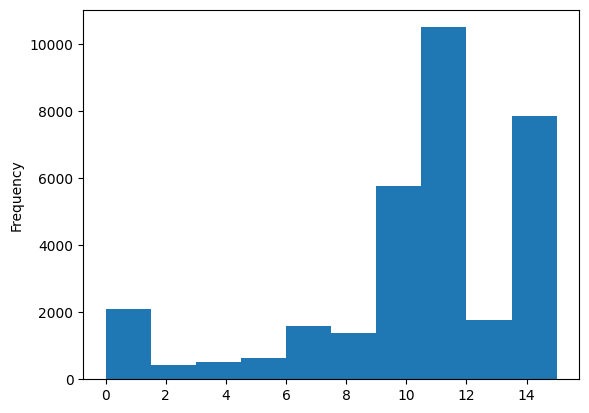

In [45]:
t3.plot(kind='hist')

In [46]:
decoded = encoder.inverse_transform(encoded)

In [47]:
print("Decoded:\n", decoded.ravel())

Decoded:
 ['Bachelors' 'Bachelors' 'HS-grad' ... 'HS-grad' 'HS-grad' 'HS-grad']


In [48]:
print("Encoded (2D):\n", encoded.ravel())  # .ravel() to print as 1-D
print("Categories:", encoder.categories_)

Encoded (2D):
 [ 9.  9. 11. ... 11. 11. 11.]
Categories: [array(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th',
       'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad',
       'Masters', 'Preschool', 'Prof-school', 'Some-college'],
      dtype=object)]


In [49]:
# [ 'Preschool','1st-4th', '5th-6th', '7th-8th', '9th','10th', '11th', '12th', 'Some-college','HS-grad','Prof-school','Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'Masters']

encoder2 = OrdinalEncoder(categories=[['Preschool','1st-4th', '5th-6th', '7th-8th', '9th','10th', '11th', '12th', 'Some-college','HS-grad','Prof-school','Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'Masters']])
encoded2 = encoder2.fit_transform(t1)
t4 = pd.Series(encoded2.ravel(), name='education_num')

Encoded (2D):
 [13. 13.  9. ...  9.  9.  9.]
Categories: [array(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th',
       '11th', '12th', 'Some-college', 'HS-grad', 'Prof-school',
       'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'Masters'],
      dtype=object)]


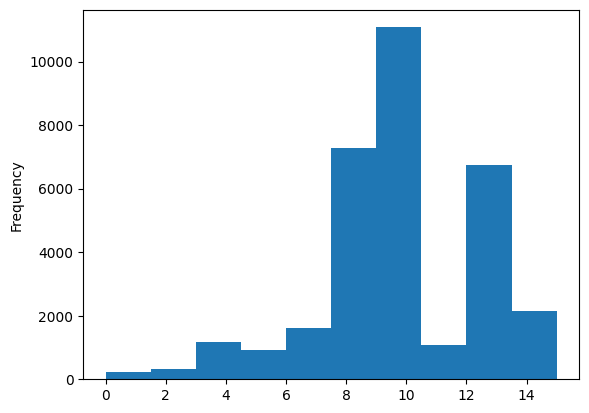

In [50]:
t4.plot(kind='hist')
print("Encoded (2D):\n", encoded2.ravel())  # .ravel() to print as 1-D
print("Categories:", encoder2.categories_)

### Below code is for testing function for evoluating models

In [51]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
#import numpy as np

# Example data
y_true = np.array([0, 1, 0, 1, 0, 1, 0, 1])
y_pred = np.array([1, 0, 0, 1, 1, 1, 0, 1])

In [52]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6250


In [53]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8



In [54]:
q=pd.crosstab(y_true, y_pred)

In [55]:
q

col_0,0,1
row_0,,
0,2,2
1,1,3
